In [127]:
# Library

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline
import shap
import lightgbm as lgb
import optuna

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier, early_stopping
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Data

In [80]:
# Read
df_train = pd.read_csv('train.tsv', sep='\t')
df_train.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
df_test = pd.read_csv('test.tsv', sep='\t')
df_test.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

# Output
df_train.head()

,id,class,left_weight,left_distance,right_weight,right_distance
0,2,2,2,4,4,3
1,9,0,2,2,1,3
2,11,0,2,4,4,1
3,13,2,3,3,3,5
4,16,0,3,4,5,2


In [82]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              312 non-null    int64
 1   class           312 non-null    int64
 2   left_weight     312 non-null    int64
 3   left_distance   312 non-null    int64
 4   right_weight    312 non-null    int64
 5   right_distance  312 non-null    int64
dtypes: int64(6)
memory usage: 14.8 KB


In [84]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              313 non-null    int64
 1   left_weight     313 non-null    int64
 2   left_distance   313 non-null    int64
 3   right_weight    313 non-null    int64
 4   right_distance  313 non-null    int64
dtypes: int64(5)
memory usage: 12.4 KB


# EDA

In [86]:
df_train.describe()

,id,class,left_weight,left_distance,right_weight,right_distance
count,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000
mean,312.644231,1.009615,3.025641,2.942308,2.987179,3.003205
std,179.149325,0.957239,1.436541,1.444539,1.400446,1.444578
min,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,150.750000,0.000000,2.000000,2.000000,2.000000,2.000000
50%,308.000000,1.000000,3.000000,3.000000,3.000000,3.000000
75%,462.500000,2.000000,4.000000,4.000000,4.000000,4.000000
max,622.000000,2.000000,5.000000,5.000000,5.000000,5.000000


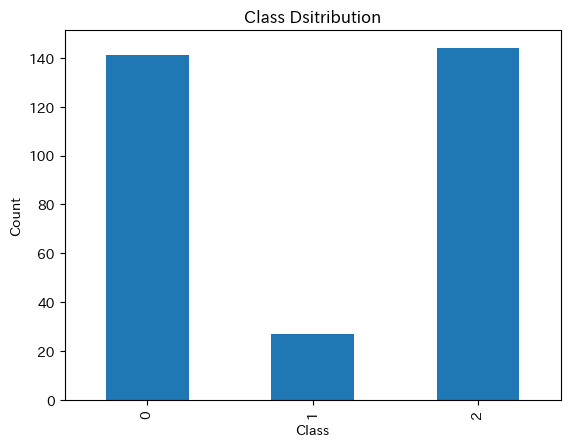

In [90]:
# Viz
df_train['class'].value_counts().sort_index().plot(kind='bar')
plt.title('Class Dsitribution')
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

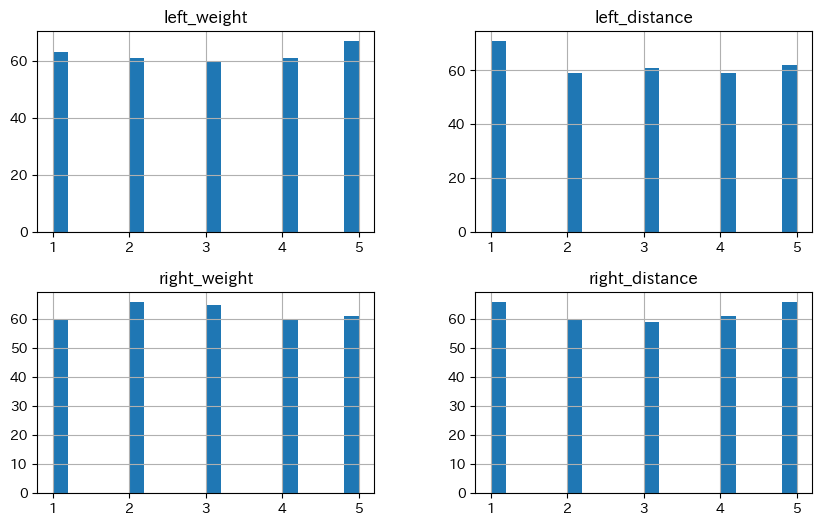

In [94]:
# Viz
features = ['left_weight', 'left_distance', 'right_weight', 'right_distance']
df_train[features].hist(bins=20, figsize=(10, 6) )
plt.show()

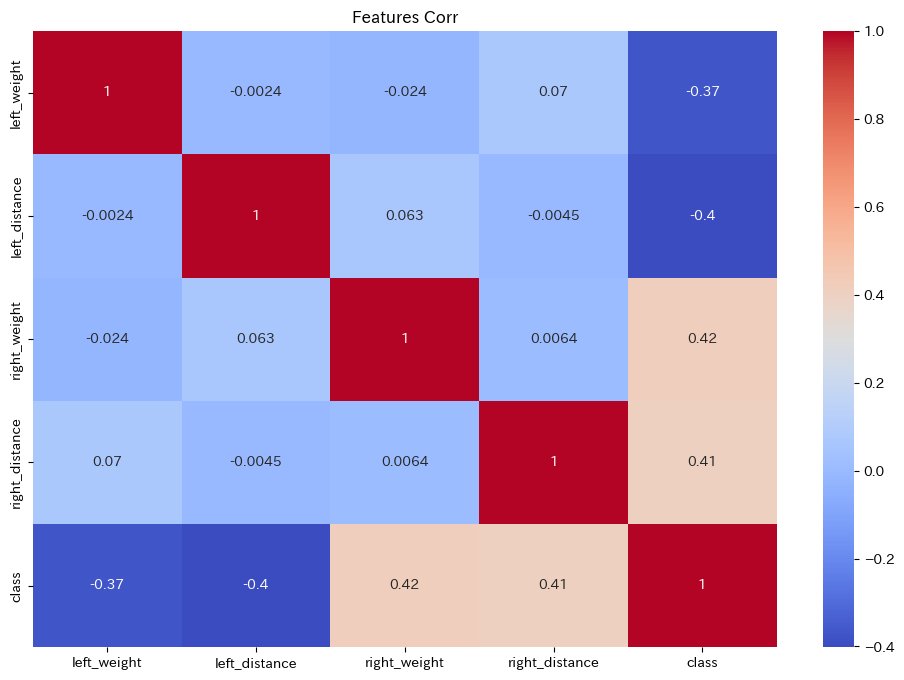

In [100]:
# Viz
plt.figure(figsize=(12, 8) )
sns.heatmap(df_train[features + ['class'] ].corr(), annot=True, cmap='coolwarm')
plt.title('Features Corr')
plt.show()

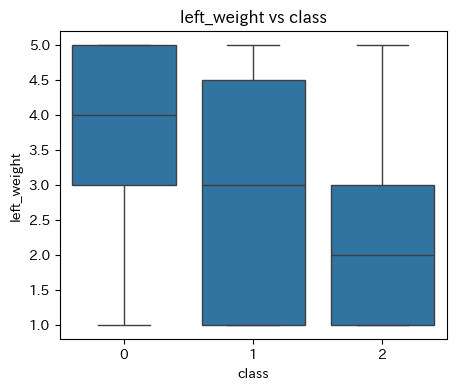

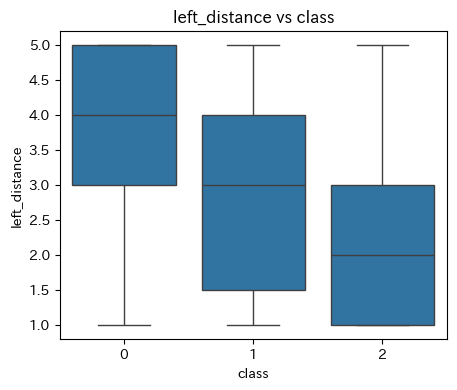

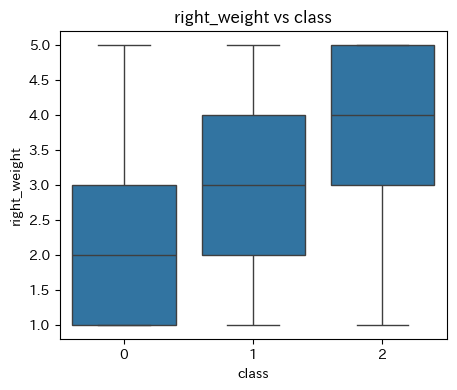

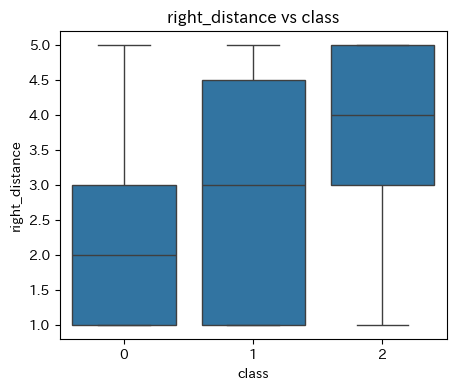

In [102]:
# Viz
for col in features:
    plt.figure(figsize=(5, 4) )
    sns.boxplot(x='class', y=col, data=df_train)
    plt.title(f'{col} vs class')
    plt.show()

# Prepare

In [131]:
def prepare_features(df):
    df['left_moment'] = df['left_weight'] * df['left_distance']
    df['right_moment'] = df['right_weight'] * df['right_distance']
    df['diff_weight'] = df['left_weight'] - df['right_weight']
    df['diff_distance'] = df['left_distance'] - df['right_distance']
    df['diff_moment'] = df['left_moment'] - df['right_moment']
    return df

# Model

In [137]:
# features
features = [
    'left_weight', 'left_distance', 'right_weight', 'right_distance',
    'left_moment', 'right_moment', 'diff_weight', 'diff_distance', 'diff_moment'
]

df_train = prepare_features(df_train)
X = df_train[features]
y = df_train['class']

# Split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [141]:
# Model
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

# Pred
y_pred = model_rf.predict(X_valid)
print("Accuracy:", accuracy_score(y_valid, y_pred) )

Accuracy: 1.0


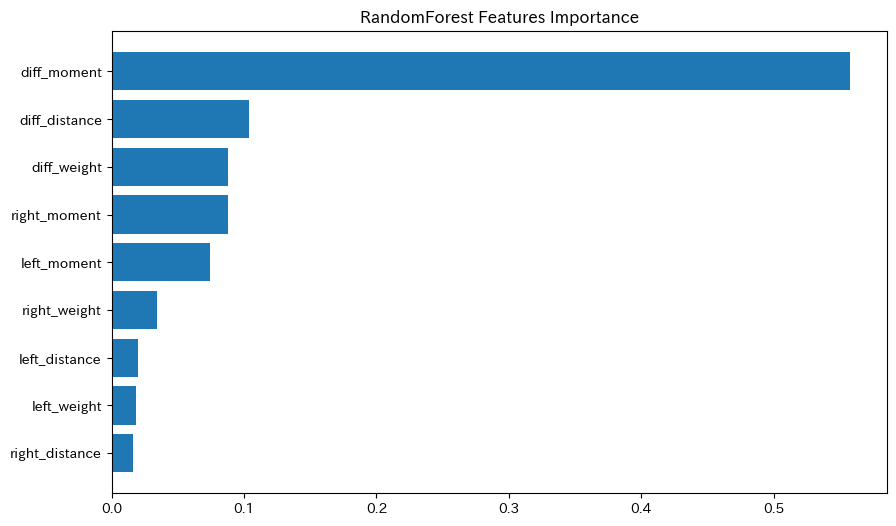

In [159]:
# Importances
importances = model_rf.feature_importances_
df_features_importance = pd.DataFrame({
    'features': features,
    'importance': importances
}).sort_values('importance', ascending=True)

# Viz
plt.figure(figsize=(10, 6) )
plt.barh(df_features_importance['features'], df_features_importance['importance'])
plt.title('RandomForest Features Importance')
plt.show()

# Submit

In [164]:
# Retrain
model_rf.fit(X, y)

# features
df_test = prepare_features(df_test)
X_test = df_test[features]

In [166]:
# Pred
y_test_pred = model_rf.predict(X_test)

# Submit
df_submit = pd.DataFrame({
    'id': df_test['id'],
    'class': y_test_pred
})

df_submit.to_csv('submisson_20250421_1.csv', index=False, header=False)